# Pulse Creation by Chalmers

In [98]:
class Pulse:
    """Represents physical pulses played by an AWG.

    Parameters
    ----------
    complex : bool
        If True, pulse has both I and Q, otherwise it's real valued.
        Drag only applies for complex waveforms.

    Attributes
    ----------
    amplitude : float
        Pulse amplitude.
    width : float
        Pulse width.
    plateau : float
        Pulse plateau.
    frequency : float
        SSB frequency.
    phase : float
        Pulse phase.
    use_drag : bool
        If True, applies DRAG correction.
    drag_coefficient : float
        Drag coefficient.
    drag_detuning : float
        Applies a frequnecy detuning for DRAG pulses.
    start_at_zero : bool
        If True, forces the pulse to start in 0.

    """

    def __init__(self, complex):

        # set variables
        self.amplitude = 0.5
        self.width = 10E-9
        self.plateau = 0.0
        self.frequency = 0.0
        self.phase = 0.0
        self.use_drag = False
        self.drag_coefficient = 0.0
        self.drag_detuning = 0.0
        self.start_at_zero = False
        self.complex = complex

    def total_duration(self):
        """Get the total duration for the pulse.

        Returns
        -------
        float
            Total duration in seconds.

        """
        raise NotImplementedError()

    def calculate_envelope(self, t0, t):
        """Calculate pulse envelope.

        Parameters
        ----------
        t0 : float
            Pulse position, referenced to center of pulse.

        t : numpy array
            Array with time values for which to calculate the pulse envelope.

        Returns
        -------
        waveform : numpy array
            Array containing pulse envelope.

        """
        raise NotImplementedError()

    def calculate_waveform(self, t0, t):
        """Calculate pulse waveform including phase shifts and SSB-mixing.

        Parameters
        ----------
        t0 : float
            Pulse position, referenced to center of pulse.

        t : numpy array
            Array with time values for which to calculate the pulse waveform.

        Returns
        -------
        waveform : numpy array
            Array containing pulse waveform.

        """
        y = self.calculate_envelope(t0, t)
        # Make sure the waveform is zero outside the pulse
        y[t < (t0 - self.total_duration() / 2)] = 0
        y[t > (t0 + self.total_duration() / 2)] = 0

        if self.use_drag and self.complex:
            beta = self.drag_coefficient / (t[1] - t[0])
            y = y + 1j * beta * np.gradient(y)
            y = y * np.exp(1j * 2 * np.pi * self.drag_detuning *
                           (t - t0 + self.total_duration() / 2))

        if self.complex:
            # Apply phase and SSB
            phase = self.phase
            # single-sideband mixing, get frequency
            omega = 2 * np.pi * self.frequency
            # apply SSBM transform
            data_i = (y.real * np.cos(omega * t - phase) +
                      -y.imag * np.cos(omega * t - phase + +np.pi / 2))
            data_q = (y.real * np.sin(omega * t - phase) +
                      -y.imag * np.sin(omega * t - phase + +np.pi / 2))
            y = data_i + 1j * data_q
        else:
            phase = self.phase
            omega = 2 * np.pi * self.frequency
            y = y * np.cos(omega*t-phase)
        return y


class Gaussian(Pulse):
    def __init__(self, complex):
        super().__init__(complex)
        self.truncation_range = 5

    def total_duration(self):
        return self.truncation_range * self.width + self.plateau

    def calculate_envelope(self, t0, t):
        # width is two t std
        # std = self.width/2;
        # alternate; std is set to give total pulse area same as a square
        std = self.width / np.sqrt(2 * np.pi)
        values = np.zeros_like(t)
        if self.plateau == 0:
            # pure gaussian, no plateau
            if std > 0:
                values = np.exp(-(t - t0)**2 / (2 * std**2))
        else:
            # add plateau
            values = np.array(
                ((t >= (t0 - self.plateau / 2)) & (t <
                                                   (t0 + self.plateau / 2))),
                dtype=float)
            if std > 0:
                # before plateau
                values += ((t < (t0 - self.plateau / 2)) * np.exp(
                    -(t - (t0 - self.plateau / 2))**2 / (2 * std**2)))
                # after plateau
                values += ((t >= (t0 + self.plateau / 2)) * np.exp(
                    -(t - (t0 + self.plateau / 2))**2 / (2 * std**2)))

        # TODO  Fix this
        if self.start_at_zero:
            values = values - values.min()
            values = values / values.max()
        values = values * self.amplitude

        return values


class Ramp(Pulse):
    def total_duration(self):
        return 2 * self.width + self.plateau

    def calculate_envelope(self, t0, t):
        # rising and falling slopes
        vRise = ((t - (t0 - self.plateau / 2 - self.width)) / self.width)
        vRise[vRise < 0.0] = 0.0
        vRise[vRise > 1.0] = 1.0
        vFall = (((t0 + self.plateau / 2 + self.width) - t) / self.width)
        vFall[vFall < 0.0] = 0.0
        vFall[vFall > 1.0] = 1.0
        values = vRise * vFall

        values = values * self.amplitude

        return values


class Square(Pulse):
    def total_duration(self):
        return self.width + self.plateau

    def calculate_envelope(self, t0, t):
        # reduce risk of rounding errors by putting checks between samples
        if len(t) > 1:
            t0 += (t[1] - t[0]) / 2.0

        values = ((t >= (t0 - (self.width + self.plateau) / 2)) &
                  (t < (t0 + (self.width + self.plateau) / 2)))

        values = values * self.amplitude

        return values


class Cosine(Pulse):
    def total_duration(self):
        return self.width + self.plateau

    def calculate_envelope(self, t0, t):
        tau = self.width
        if self.plateau == 0:
            values = (self.amplitude / 2 *
                      (1 - np.cos(2 * np.pi * (t - t0 + tau / 2) / tau)))
        else:
            values = np.ones_like(t) * self.amplitude
            values[t < t0 - self.plateau / 2] = self.amplitude / 2 * \
                (1 - np.cos(2 * np.pi *
                            (t[t < t0 - self.plateau / 2] - t0 +
                             self.plateau / 2 + tau / 2) / tau))
            values[t > t0 + self.plateau / 2] = self.amplitude / 2 * \
                (1 - np.cos(2 * np.pi *
                            (t[t > t0 + self.plateau / 2] - t0 -
                             self.plateau / 2 + tau / 2) / tau))

        return values


class CZ(Pulse):
    def __init__(self, *args, **kwargs):
        super().__init__(False)
        # For CZ pulses
        self.F_Terms = 1
        self.Coupling = 20E6
        self.Offset = 300E6
        self.Lcoeff = np.array([0.3])
        self.dfdV = 500E6
        self.qubit = None
        self.negative_amplitude = False

        self.t_tau = None

    def total_duration(self):
        return self.width+self.plateau

    def calculate_envelope(self, t0, t):
        if self.t_tau is None:
            self.calculate_cz_waveform()

        # Plateau is added as an extra extension of theta_f.
        theta_t = np.ones(len(t)) * self.theta_i
        for i in range(len(t)):
            if 0 < (t[i] - t0 + self.plateau / 2) < self.plateau:
                theta_t[i] = self.theta_f
            elif (0 < (t[i] - t0 + self.width / 2 + self.plateau / 2) <
                  (self.width + self.plateau) / 2):
                theta_t[i] = np.interp(
                    t[i] - t0 + self.width / 2 + self.plateau / 2, self.t_tau,
                    self.theta_tau)
            elif (0 < (t[i] - t0 + self.width / 2 + self.plateau / 2) <
                  (self.width + self.plateau)):
                theta_t[i] = np.interp(
                    t[i] - t0 + self.width / 2 - self.plateau / 2, self.t_tau,
                    self.theta_tau)

        df = 2*self.Coupling * (1 / np.tan(theta_t) - 1 / np.tan(self.theta_i))

        if self.qubit is None:
            # Use linear dependence if no qubit was given
            values = df / self.dfdV
        else:
            values = self.qubit.df_to_dV(df)
        if self.negative_amplitude is True:
            values = -values

        return values

    def calculate_cz_waveform(self):
        """Calculate waveform for c-phase and store in object"""
        # notation and calculations are based on
        # "Fast adiabatic qubit gates using only sigma_z control"
        # PRA 90, 022307 (2014)
        # Initial and final angles on the |11>-|02> bloch sphere
        self.theta_i = np.arctan(2*self.Coupling / self.Offset)
        self.theta_f = np.arctan(2*self.Coupling / self.amplitude)
        log.log(msg="calc", level=30)

        # Renormalize fourier coefficients to initial and final angles
        # Consistent with both Martinis & Geller and DiCarlo 1903.02492
        Lcoeff = self.Lcoeff
        Lcoeff[0] = (((self.theta_f - self.theta_i) / 2)
                     - np.sum(self.Lcoeff[range(2, self.F_Terms, 2)]))

        # defining helper variabels
        n = np.arange(1, self.F_Terms + 1, 1)
        n_points = 1000  # Number of points in the numerical integration

        # Calculate pulse width in tau variable - See paper for details
        tau = np.linspace(0, 1, n_points)
        self.theta_tau = np.zeros(n_points)
        # This corresponds to the sum in Eq. (15) in Martinis & Geller
        for i in range(n_points):
            self.theta_tau[i] = (
                np.sum(Lcoeff * (1 - np.cos(2 * np.pi * n * tau[i]))) +
                self.theta_i)
        # Now calculate t_tau according to Eq. (20)
        t_tau = np.trapz(np.sin(self.theta_tau), x=tau)
        # Find the width in units of tau:
        Width_tau = self.width / t_tau

        # Calculating time as functions of tau
        # we normalize to width_tau (calculated above)
        tau = np.linspace(0, Width_tau, n_points)
        self.t_tau = np.zeros(n_points)
        for i in range(n_points):
            if i > 0:
                self.t_tau[i] = np.trapz(
                    np.sin(self.theta_tau[0:i+1]), x=tau[0:i+1])


class NetZero(CZ):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.slepian = None

    def total_duration(self):
        return 2*self.slepian.total_duration()

    def calculate_cz_waveform(self):
        self.slepian = CZ()
        self.slepian.__dict__ = copy.copy(self.__dict__)
        self.slepian.width /= 2
        self.slepian.plateau /= 2
        self.slepian.calculate_cz_waveform()

    def calculate_envelope(self, t0, t):
        return (self.slepian.calculate_envelope(t0-self.total_duration()/4, t) -
                self.slepian.calculate_envelope(t0+self.total_duration()/4, t))

# Imports

In [99]:
# REQUIRED for c3
import qutip as qt
# FUTURE: import tensorflow as tf 
# REASON: tensorflow will become a hard requirement for c3 as certain 
#         functionality (i.e. GOAT) will depend on it


# optional/additional imports 
from math import * # pi 
import numpy as np
import matplotlib.pyplot as plt  # for plotting
import os   # for interacting with operating system, i.e. creating files

# Pulse Specification in c3


## Example: Cosine Pulse

In [100]:
pulse1 = Cosine(False)
pulse1.amplitude = 0.5
pulse1.width = 10E-9
pulse1.plateau = 0.4e-7
pulse1.frequency = 0.0
pulse1.phase = 0.0
pulse1.use_drag = False
pulse1.drag_coefficient = 0.0
pulse1.drag_detuning = 0.0
pulse1.start_at_zero = False
pulse1.complex = False

t0 = 50e-9

def cos_envelope(t, idx, guess):
    tau = guess[idx['width']]
    plateau = guess[idx['plateau']]
    t0 = guess[idx['t0']]
    if plateau == 0:
        values = (1.0 / 2.0 *
                  (1 - np.cos(2 * np.pi * (t - t0 + tau / 2) / tau)))
    else:
        values = np.ones_like(t)
        values[t < t0 - plateau / 2] = 1.0 / 2.0 * \
            (1 - np.cos(2 * np.pi *
                        (t[t < t0 - plateau / 2] - t0 +
                         plateau / 2 + tau / 2) / tau))
        values[t > t0 + plateau / 2] = 1.0 / 2.0 * \
            (1 - np.cos(2 * np.pi *
                        (t[t > t0 + plateau / 2] - t0 -
                         plateau / 2 + tau / 2) / tau))
        
    total_duration = tau + plateau # why not 2 * width?
        
    values[t < (t0 - total_duration / 2)] = 0
    values[t > (t0 + total_duration / 2)] = 0        

    return values    
    
    
cosine_pulse = {
    'control1':{
        'carrier1':{
            'freq' : 6e9*2*pi, #taken from a c3 example still needs to be adjusted to Chalmers setup
            'pulses':{
                'pulse':{
                    #the token 'pulse' is free to chose i.e. 'pulse1', 'pulseX', 'p1', ...
                    'params': {
                            # required:
                            'amp': pulse1.amplitude, 
                            'xy_angle': pulse1.phase, 
                            'freq_offset': 2*pi*pulse1.frequency, 
                            # optional (params for 'func')
                            'width': pulse1.width,
                            'plateau': pulse1.plateau,
                            't0': t0
                        },
                    'func': cos_envelope
                    }                    
                }
            }
        }
    }

## Example: Gaussian Pulse

In [101]:
pulse2 = Gaussian(False)
pulse2.amplitude = 0.5
pulse2.width = 10E-9
pulse2.plateau = 0.2e-7
pulse2.frequency = 0.0
pulse2.phase = 0.0
pulse2.use_drag = False
pulse2.drag_coefficient = 0.0
pulse2.drag_detuning = 0.0
pulse2.start_at_zero = False
pulse2.complex = False

t0 = 50e-9



def gauss_envelope(t, idx, guess):
    width = guess[idx['width']]
    plateau = guess[idx['plateau']]
    t0 = guess[idx['t0']]
    start_at_zero = guess[idx['start_at_zero']]
    amp = guess[idx['amp']]
    # width is two t std
    # std = self.width/2;
    # alternate; std is set to give total pulse area same as a square
    std = width / np.sqrt(2 * np.pi)
    values = np.zeros_like(t)
    if plateau == 0:
        # pure gaussian, no plateau
        if std > 0:
            values = np.exp(-(t - t0)**2 / (2 * std**2))
    else:
        # add plateau
        values = np.array(
            ((t >= (t0 - plateau / 2)) & (t <
                                               (t0 + plateau / 2))),
            dtype=float)
        if std > 0:
            # before plateau
            values += ((t < (t0 - plateau / 2)) * np.exp(
                -(t - (t0 - plateau / 2))**2 / (2 * std**2)))
            # after plateau
            values += ((t >= (t0 + plateau / 2)) * np.exp(
                -(t - (t0 + plateau / 2))**2 / (2 * std**2)))

    # TODO  Fix this
    if start_at_zero:
        values = values - values.min()
        values = values / values.max()
    #values = values * self.amplitude

    truncation_range = 5
    total_duration = truncation_range * width + plateau
    
    # Make sure the waveform is zero outside the pulse
    values[t < (t0 - total_duration / 2)] = 0
    values[t > (t0 + total_duration / 2)] = 0
    
    return values


gaussian_pulse = {
    'control1':{
        'carrier1':{
            'freq' : 6e9*2*pi, 
            'pulses':{
                'pulse':{ #the token 'pulse' is free to chose i.e. 'pulse1', 'pulseX', 'p1', ...
                    'params': {
                            # required:
                            'amp': pulse2.amplitude, 
                            'xy_angle': pulse2.phase, 
                            'freq_offset': 2*pi*pulse2.frequency, 
                            # optional (params for 'func'):
                            'width': pulse2.width,
                            'plateau': pulse2.plateau,
                            't0': t0,
                            'start_at_zero': pulse2.start_at_zero
                        },
                    'func': gauss_envelope
                    }
                }
            }
        }
    }

# Creation of Gate Object

Represents a quantum gate with a fixed parametrization and envelope shape.

In [102]:
# import parts of c3 that are needed for the task at hand 
from c3po.main.gate import Gate as gt

# EXAMPLE: Assume X_gate is target of operation
X_gate = gt('qubit_1', qt.sigmax())

## Example: Cosine Pulse

In [103]:
X_gate.set_parameters('initial', cosine_pulse)

## Plot:
In-phase (I) components of the control signal

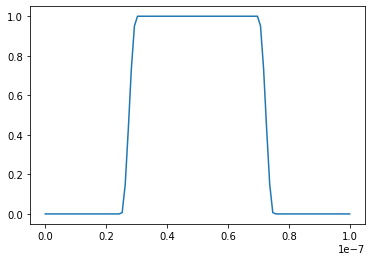

In [104]:
# default values in gate
T_final=100e-9
res=1e9

t = np.linspace(0, T_final, int(T_final*res))
iq = X_gate.get_IQ('initial')

plt.plot(t, iq['control1']['carrier1']['I'])
plt.show()

**Remark:** In c3 the signals are normalized

## Comparison
Control signal obtained with code from Chalmers

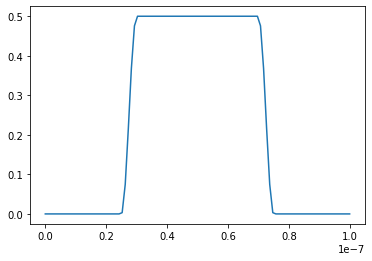

In [105]:
plt.plot(t, pulse1.calculate_waveform(t0, t))
plt.show()

## Example: Gaussian Pulse

In [106]:
X_gate.set_parameters('initial', gaussian_pulse)

## Plot:
In-phase (I) components of the control signal

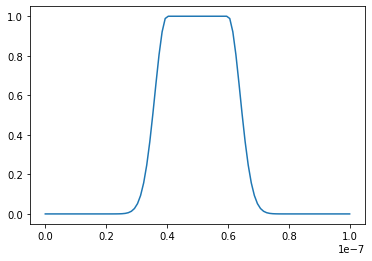

In [107]:
# default values in gate
T_final=100e-9
res=1e9

t = np.linspace(0, T_final, int(T_final*res))
iq = X_gate.get_IQ('initial')

plt.plot(t,iq['control1']['carrier1']['I'])
plt.show()

**Remark:** In c3 the signals are normalized

## Comparison
Control signal obtained with code from Chalmers

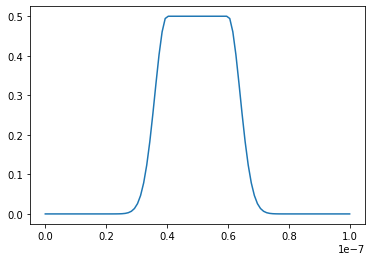

In [108]:
# amplitude scaling seems to be incorrect. factor 0.5 too much?
plt.plot(t, pulse2.calculate_waveform(t0, t))
plt.show()

# Example: Complex Pulse in c3

In [131]:
complex_pulse = {
    'control1':{
        'carrier1':{
            'freq' : 6e9*2*pi, 
            'pulses':{
                'gauss1':{ #the token 'pulse' is free to chose i.e. 'pulse1', 'pulseX', 'p1', ...
                    'params': {
                            # required:
                            'amp': pulse2.amplitude, 
                            'xy_angle': pulse2.phase, 
                            'freq_offset': 2*pi*pulse2.frequency, 
                            # optional (params for 'func'):
                            'width': pulse2.width,
                            'plateau': pulse2.plateau*0.25,
                            't0': t0-25e-9,
                            'start_at_zero': pulse2.start_at_zero
                        },
                    'func': gauss_envelope
                    },
                'gauss2':{ #the token 'pulse' is free to chose i.e. 'pulse1', 'pulseX', 'p1', ...
                    'params': {
                            # required:
                            'amp': pulse2.amplitude*2, 
                            'xy_angle': pulse2.phase, 
                            'freq_offset': 2*pi*pulse2.frequency, 
                            # optional (params for 'func'):
                            'width': pulse2.width,
                            'plateau': pulse2.plateau*0.25,
                            't0': t0+25e-9,
                            'start_at_zero': pulse2.start_at_zero
                        },
                    'func': gauss_envelope
                    },
                'cos1':{ #the token 'pulse' is free to chose i.e. 'pulse1', 'pulseX', 'p1', ...
                    'params': {
                            # required:
                            'amp': pulse2.amplitude, 
                            'xy_angle': pulse2.phase, 
                            'freq_offset': 2*pi*pulse2.frequency, 
                            # optional (params for 'func'):
                            'width': pulse2.width,
                            'plateau': pulse2.plateau*0.25,
                            't0': t0,
                        },
                    'func': cos_envelope
                    }
                }
            }
        }
    }

In [132]:
X_gate.set_parameters('initial', complex_pulse)

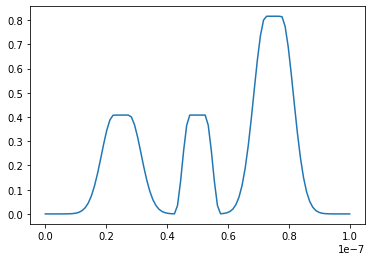

In [133]:
# default values in gate
T_final=100e-9
res=1e9

t = np.linspace(0, T_final, int(T_final*res))
iq = X_gate.get_IQ('initial')

plt.plot(t, iq['control1']['carrier1']['I'])
plt.show()